In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

def seq2vec(string, outlen, vocab):
    """
    given dictionary, convet string to a vector.
    the length of string should be shorter then outlen.
    if the length string is smaller than outlen, it will be padded with zero to make the langth the same.
    
    string: input string (length smaller than outlen)
    outlen: output length of vecotr.
    vocab: the dictionary for the encoding.
    """
    
    vector = [vocab[amino_acid] for amino_acid in string]
    vector = np.pad(vector, (0,outlen-len(vector)), constant_values=20)
    return np.array(vector)

In [115]:
#processing data

#import csv of sequence data
#drop unscaled score columns
#rename columns
data = pd.read_csv("family_101F.csv", index_col=None, header=None, skiprows=1)
data = data.drop([1,2], axis=1)
data.columns = ["seq", "len", "binding score", "digest score"]

#drop X amino acid data
#drop _ amino acid data
#drop end catalyst amino acid
#reindex dataframe
data = data[~data['seq'].str.contains('X')]
data = data[~data['seq'].str.contains('_')]
data["seq"] = data["seq"].str.replace(r'GS$', '')
data.index = range(data.shape[0])

#import csv of vocabulary
#build dictionary
vfile = pd.read_csv("vocab.csv", index_col=None, skiprows=0)
vocab = {vfile["One-Letter Code"][i]:i for i in range(len(vfile["One-Letter Code"]))}

#shuffle the dataset
np.random.seed(1)
data = shuffle(data)

In [4]:
#change vector to one-hot encoding
Tx = data["len"].max()
vector = np.array([to_categorical(seq2vec(data["seq"][i], Tx, vocab)) for i in data.index])

#rescale score to be within 0,1
scaler = MinMaxScaler()
binding_score = data["binding score"].values
binding_score = scaler.fit_transform(binding_score.reshape(len(binding_score),1))

In [8]:
#sanitary check
assert (vector.shape[1], vector.shape[2]) == (Tx, len(vocab))
assert (binding_score.shape[1] == 1)

In [10]:
units = 16
nbatch = 16

model = Sequential()
model.add(layers.SimpleRNN(units, input_shape=(Tx, len(vocab))))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

trainX = vector[:int(len(vector)*0.8)]
trainY = binding_score[:int(len(vector)*0.8)]
testX = vector[int(len(vector)*0.8):]
testY = binding_score[int(len(vector)*0.8):]

history = model.fit(trainX, trainY, validation_data=(testX,testY), epochs=20, batch_size=nbatch, verbose=1)

Train on 9239 samples, validate on 2310 samples
Epoch 1/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 0.0080 - val_loss: 0.0077
Epoch 2/20
9239/9239 [==============================] - 9s 1ms/sample - loss: 0.0073 - val_loss: 0.0072
Epoch 3/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 4/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0069 - val_loss: 0.0067
Epoch 5/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0067 - val_loss: 0.0063
Epoch 6/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0064 - val_loss: 0.0064
Epoch 7/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 8/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 0.0060 - val_loss: 0.0060
Epoch 9/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 0.0059 - val_loss: 0.0057
Epoch 10

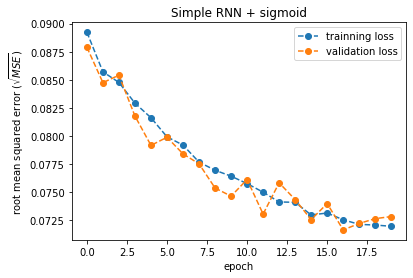

In [11]:
plt.plot(np.sqrt(history.history["loss"]), '--o', label='trainning loss');
plt.plot(np.sqrt(history.history["val_loss"]), '--o', label='validation loss');
plt.title("Simple RNN + sigmoid");
plt.ylabel("root mean squared error $(\sqrt{MSE})$");
plt.xlabel("epoch");
plt.legend();

Text(0, 0.5, 'digest score')

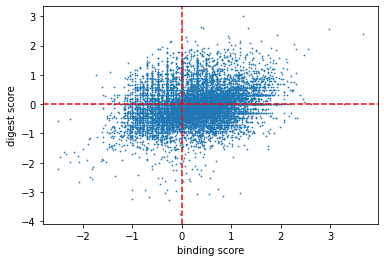

In [24]:
plt.scatter(data["binding score"], data["digest score"], s=0.5)
plt.axhline(y=0, c="r", ls='--')
plt.axvline(x=0, c="r", ls='--')
plt.xlabel("binding score")
plt.ylabel("digest score")

In [124]:
data.loc[(data["binding score"] > 0) & (data["digest score"] > 0), "label"] = 0
data.loc[(data["binding score"] < 0) & (data["digest score"] < 0), "label"] = 1
data.loc[(data["binding score"] >= 0) & (data["digest score"] <= 0), "label"] = 2
data.loc[(data["binding score"] <= 0) & (data["digest score"] >= 0), "label"] = 3

In [137]:
units = 16
nbatch = 16

model = Sequential()
model.add(layers.SimpleRNN(units, input_shape=(Tx, len(vocab))))
model.add(layers.Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

trainX = vector[:int(len(vector)*0.8)]
trainY = data["label"][:int(len(vector)*0.8)].astype("int32")
testX = vector[int(len(vector)*0.8):]
testY = data["label"][int(len(vector)*0.8):].astype("int32")

history = model.fit(trainX, trainY, validation_data=(testX,testY), epochs=20, batch_size=nbatch, verbose=1)

Train on 9239 samples, validate on 2310 samples
Epoch 1/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 1.1972 - accuracy: 0.4603 - val_loss: 1.1203 - val_accuracy: 0.5182
Epoch 2/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 1.1099 - accuracy: 0.5112 - val_loss: 1.0906 - val_accuracy: 0.5325
Epoch 3/20
9239/9239 [==============================] - 10s 1ms/sample - loss: 1.0958 - accuracy: 0.5239 - val_loss: 1.0740 - val_accuracy: 0.5385
Epoch 4/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 1.0796 - accuracy: 0.5310 - val_loss: 1.0611 - val_accuracy: 0.5502
Epoch 5/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 1.0719 - accuracy: 0.5365 - val_loss: 1.0450 - val_accuracy: 0.5567
Epoch 6/20
9239/9239 [==============================] - 11s 1ms/sample - loss: 1.0594 - accuracy: 0.5449 - val_loss: 1.0333 - val_accuracy: 0.5623
Epoch 7/20
9239/9239 [==============================] - 11s 1ms/sample

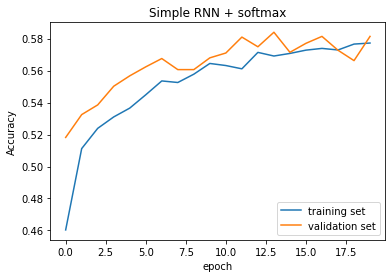

In [143]:
plt.plot(history.history["accuracy"], '-', label='training set');
plt.plot(history.history["val_accuracy"], '-', label='validation set');
plt.title("Simple RNN + softmax");
plt.ylabel("Accuracy");
plt.xlabel("epoch");
plt.legend();

In [146]:
y_pred = model.predict(testX)

In [149]:
np.argmax(y_pred, axis=1)

array([3, 3, 3, ..., 0, 2, 3], dtype=int64)

In [151]:
testY.values

array([3, 3, 3, ..., 0, 2, 0])